# Lab on Bandit Algorithms

Author: Claire Vernade (claire.vernade@uni-tuebingen.de)


In [1]:
import numpy as np
# from display import plot_regret

from matplotlib import pyplot as plt
import seaborn as sns
colors = sns.color_palette('colorblind')

## Step 1 : the Bandit environment
The bandit environment is a very simple RL environment:
* There is only 1 state: this means actions do not imply change of state
* There are K actions
* The reward function is only action-dependent

### Can you implement such class? Complete the reward computation. 

In [2]:
class Bandit():
    
    def __init__(self, means, model='gaussian', var=1.):
        self.model = model
        self.K = np.size(means)
        self.means = means
        self.var = var
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment"""
        if self.model == 'gaussian':
            # TODO: add code here 
            mean = self.means[action]
            reward = np.random.normal(mean, np.sqrt(self.var))
            return reward
        elif self.model == 'bernoulli':
            mean = self.means[action]
            reward = np.random.binomial(1, mean)
            return reward
        else: # potentially add Bernoulli model option (not needed for exercise)
            raise NotImplementedError('only Gaussian rewards are implemented so far')
        
        

In [3]:
#test
means = [0.2, 0.5, 0.8]

b1 = Bandit(means, model='gaussian')
b2 = Bandit(means, model='bernoulli')

print("gaussian samples (arm 2):", [b1.get_reward(2) for _ in range(5)])
print("bernoulli samples (arm 2):", [b2.get_reward(2) for _ in range(5)])


gaussian samples (arm 2): [0.37808012852198286, 1.1801821579732583, -0.6055733886250858, 1.0669607547491784, 2.4028323791516275]
bernoulli samples (arm 2): [1, 0, 1, 1, 1]


### Remarks / Questions:
* The bandit environment is characterized by the family of distributions of the actions, here controlled by the keyword "model";
* Building this environment, we assumed that the models admissible are parametrized by their mean *only*. Note in particular that the experimenter needs to fix the variance of the Gaussian for all arms (here with only one value, but there could be one value per arm as long as these values are known and fixed). Keep in mind that the variance is known, it is important in the construction of UCB and Thompson Sampling later. 
* Bonus: It can be useful to be able to sample binary rewards. Can you implement a new model option 'bernoulli' and the according reward sampling function?

## Step 2: Bandit agents
We have seen in class a variety of bandit algorithms, ranging from the most simple policies ($\epsilon$-greedy,...) to the (near-)optimal UCB. But so far we only gave *theoretical* guarantees, that hold under a set of hypotheses... note also the heavy usage of big-O notations in those theorems: this means there are hidden constants everywhere!  *It is always a good scientific practice to empirically validate the theoretical claims*, so we are going to do just that :)

For that purpose, we need a few more things: 
* Bandit agents: we will implement $\epsilon$-greedy, Explore-Then-Commit and UCB,
* We recommend that you start with $\epsilon$-greedy and test it using Section 3 before moving on to more complex agents. 

In [4]:
class EpsGreedy():
    
    def __init__(self, environment, epsilon):
        """ 
        instantiate the agent using only the available information from the environment (i.e. not the means)
        => environment only provides K (number of available actions) here.
        """
        self.epsilon = epsilon
        self.K = environment.K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def get_action(self):
        """
        Select an action based on epsilon-greedy strategy.
        """
        #explore with probability ε
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.K)
        else:
            #exploit with probability 1− ε
            avg_rewards = self.count_rewards / (self.count_actions + 1e-6)
            action = np.argmax(avg_rewards)

        #track which action was chosen
        self.count_actions[action] += 1
        return action

    def receive_reward(self, action, reward):
        # TODO: implement the update of the reward counts
        self.count_rewards[action] += reward    
        self.t += 1
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'eps-greedy('+str(self.epsilon)+')'
        

class ETC():
    
    def __init__(self, environment, m):
        " instantiate the agent using only the available information from the environment (i.e. not the means)"
        self.m = m
        self.K = environment.K
        self.total_exploration = self.m * self.K
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0  
        self.commit_arm = None
    
    def get_action(self):
        #exploration
        if self.t < self.total_exploration:
            #each arm is pulled m times
            return self.t // self.m  
        #commitment
        else:
           #pull the committed arm with greatest average collected during the exploration rounds
            return self.commit_arm
        
        
    def receive_reward(self, action, reward):
        
        self.count_actions[action] += 1
        self.count_rewards[action] += reward
        
        
        self.t += 1
        
        #if we finished exploring, decide which arm to commit to
        if self.t == self.total_exploration:

            #calculate empirical mean reward for each arm
            empirical_means = self.count_rewards / self.count_actions

            #set commit_arm to the arm with greatest average
            self.commit_arm = np.argmax(empirical_means)
 
        
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'ETC('+str(self.m)+')'
    
    
class UCB():
    def __init__(self, environment, var):
        self.K = environment.K
        self.var = var
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0  
        
    def get_action(self):
        ## TODO: Implement UCB
        if self.t < self.K:
            #play each arm once
            action = self.t
            return action
        
        #calculate UCB scores per arm
        ucb_scores = np.zeros(self.K)
        for a in range(self.K):
            if self.count_actions[a] >0:
                emp_mean = self.count_rewards[a] / self.count_actions[a]
                bonus = np.sqrt((2 * self.var * np.log(self.t)) / self.count_actions[a])
                ucb_scores[a] = emp_mean + bonus
            else:
                #if an arm has not been pulled yet,set high score for more exploration
                ucb_scores[a] = float('inf')
        #select arm with the highest ucb score
        action = np.argmax(ucb_scores)
        return action
        
    def receive_reward(self, action, reward):
        self.count_rewards[action] += reward
        self.count_actions[action] += 1
        self.t += 1
        
    def reset(self):
        self.count_actions = np.zeros(self.K)
        self.count_rewards = np.zeros(self.K)
        self.t = 0
        
    def name(self):
        return 'UCB('+str(self.var)+')'        
            
        

In [5]:
#test
means = [0.2, 0.5, 0.8]      
env = Bandit(means, model='gaussian')
agent = ETC(env, m=3)           #explore each arm 3 times

print("test etc agent:\n")

for t in range(15):
    action = agent.get_action() #agent selects action
    reward = env.get_reward(action) #envt returns reward
    agent.receive_reward(action, reward) #agent updates its internal state with this reward

    print(f"t = {t+1:2d}, action = {action}, reward = {reward:.2f}")

print("\nempirical means per arm:")
emp_means = agent.count_rewards / (agent.count_actions + 1e-6)
for i, m in enumerate(emp_means):
    print(f"  Arm {i}: mean ≈ {m:.3f}, count = {int(agent.count_actions[i])}")

print(f"\ncommitted arm after exploration: {agent.commit_arm}")


test etc agent:

t =  1, action = 0, reward = 1.62
t =  2, action = 0, reward = -0.04
t =  3, action = 0, reward = 1.63
t =  4, action = 1, reward = 0.58
t =  5, action = 1, reward = -0.05
t =  6, action = 1, reward = 0.35
t =  7, action = 2, reward = 1.05
t =  8, action = 2, reward = -0.50
t =  9, action = 2, reward = 0.58
t = 10, action = 0, reward = 0.01
t = 11, action = 0, reward = 0.94
t = 12, action = 0, reward = 0.28
t = 13, action = 0, reward = 2.60
t = 14, action = 0, reward = -1.16
t = 15, action = 0, reward = 0.31

empirical means per arm:
  Arm 0: mean ≈ 0.690, count = 9
  Arm 1: mean ≈ 0.294, count = 3
  Arm 2: mean ≈ 0.378, count = 3

committed arm after exploration: 0


## Step 3: Play !
We have an environment and a policy, we now must make them play together and collect the data so that we can observe the results.

### The role of the input ``Nmc`` in the ``play`` function: 
The theorems that bound the regret are either in expectation or with high probability, so to validate them empirically, we need to observe *more than one game*. This is a very important part of these experiments: we want to build a _monte-carlo estimator of the regret_, which plays several games and allows us to observe some statistics of all trajectories. This will allow us to control that the regret does not "explode" once in a while, and that the *expectation* over the various sources of randomness (agent and environment) is under control. 
Long story short: the more you run trajectories, the better is your estimate of the regret and the more meaningful are your error bars :)

### Building a game player, with regret loader:
* We want to play a T-step game (horizon T) between an environment and an agent
* We want to record the regret of our agent at every step (the agent does *not* see this!)
* We want to be able to compare agents on a fixed environment

We provide the implementation, so nothing to be changed here.

In [6]:
def play(environment, agent, Nmc, T):
    
    data = np.zeros((Nmc, T))
    best_reward = np.max(environment.means)
#     print(best_reward)
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):           
            action = agent.get_action()
#             print('action'+str(action))
            reward = environment.get_reward(action)
            agent.receive_reward(action, reward)
#             print(reward)
            data[n,t]= best_reward - reward
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent, Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

### A plotting function

Also no need to change anything here

In [7]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """
    
    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret
        
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)
        
#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)
        
        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)
        
    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None: 
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))
        
    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

## Observe the results and make critical observations

We are now ready to run an experiment and observe the results


C:\Users\mertb\AppData\Local\Temp\ipykernel_12836\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


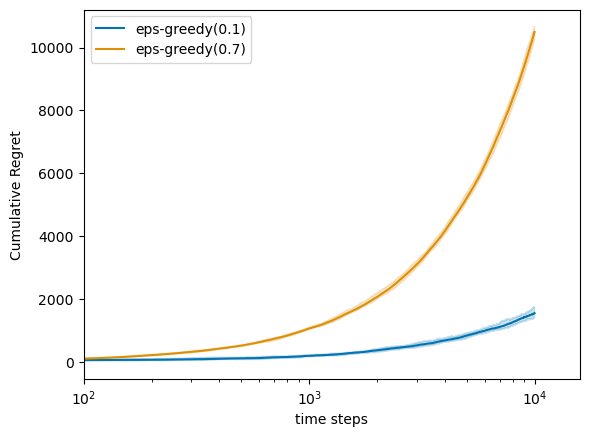

In [8]:
means = np.array([0., 1., 2., 3.])
basicGaussianBandit = Bandit(means)
epsgreedy01 = EpsGreedy(basicGaussianBandit, epsilon=0.1)
epsgreedy07 = EpsGreedy(basicGaussianBandit, epsilon=0.7)

firstregrets = experiment(basicGaussianBandit, [epsgreedy01, epsgreedy07], Nmc=10, T=10000)

plot_regret(firstregrets, logscale=True)

### Critical observations:
* Does it seem right ? Remember that we are trying to validate theory so we should be able to check that the theorem is true. If not... two options: our code has a bug or our theorem proof has a bug :S (or hypotheses are violated).
* What is the shape of the regret ? Do you think this policy is consistent ? Optimal ? How could you check ? 
* Which policy is the best? Is it statistically significant ?
* Can we do better ? (see Step 5 for more)



## Step 4: UCB

C:\Users\mertb\AppData\Local\Temp\ipykernel_12836\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


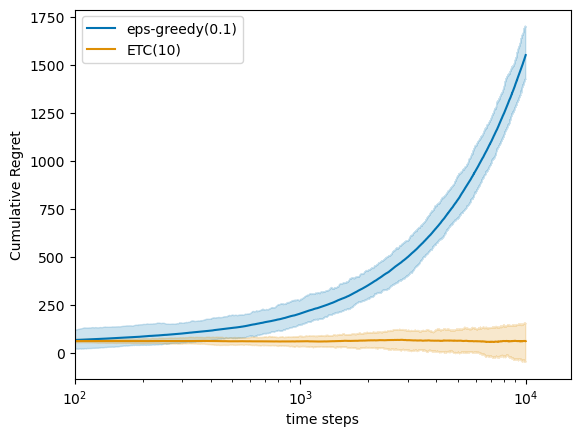

In [16]:
means = np.array([0., 1., 2., 3.])
small_var_GaussianBandit = Bandit(means, var=0.5)
agent1 = EpsGreedy(small_var_GaussianBandit, epsilon=0.1)
agent2 = ETC(small_var_GaussianBandit, m=10)

regrets_small_var = experiment(small_var_GaussianBandit, [agent1, agent2], Nmc=100, T=10000)
plot_regret(regrets_small_var, logscale=True)

C:\Users\mertb\AppData\Local\Temp\ipykernel_12836\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


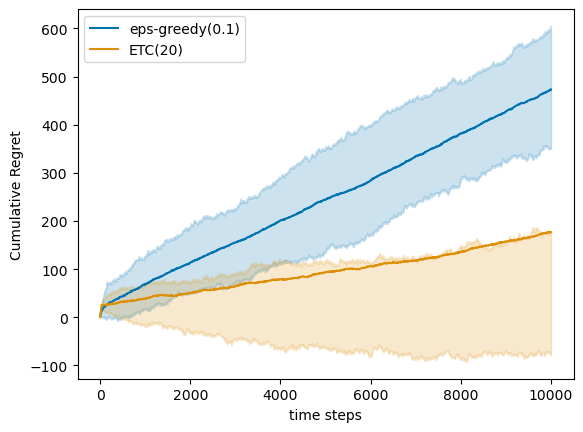

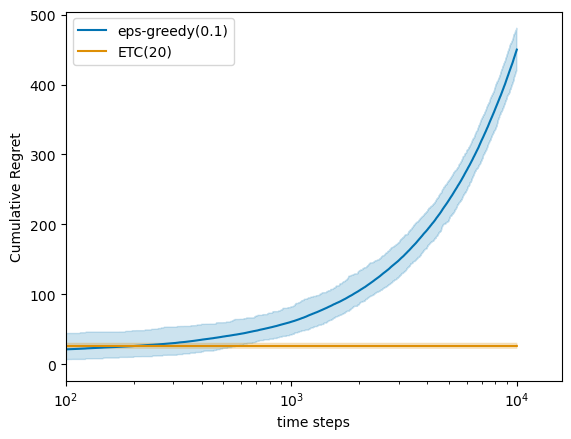

In [17]:
means = np.array([0.2, 0.5, 1])

gaussian_bandit = Bandit(means, model='gaussian', var=1.0)
eps_greedy = EpsGreedy(gaussian_bandit, epsilon=0.1)
etc_agent = ETC(gaussian_bandit, m=20)

regrets_gaussian = experiment(gaussian_bandit, [eps_greedy, etc_agent], Nmc=100, T=10000)
plot_regret(regrets_gaussian)

bernoulli_bandit = Bandit(means, model='bernoulli')
eps_greedy_b = EpsGreedy(bernoulli_bandit, epsilon=0.1)
etc_agent_b = ETC(bernoulli_bandit, m=20)

regrets_bernoulli = experiment(bernoulli_bandit, [eps_greedy_b, etc_agent_b], Nmc=100, T=10000)
plot_regret(regrets_bernoulli, logscale=True)

C:\Users\mertb\AppData\Local\Temp\ipykernel_12836\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


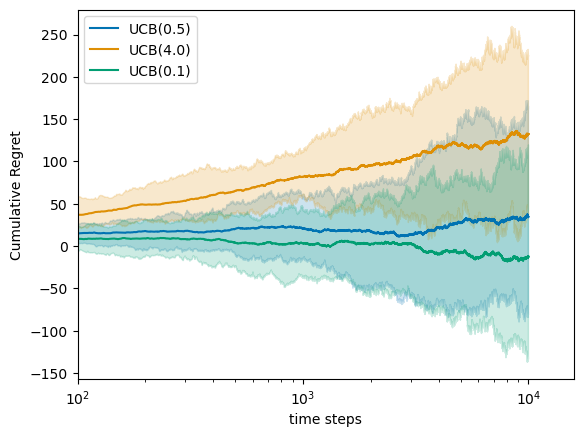

In [19]:
UCB_exact = UCB(basicGaussianBandit, var=0.5)
badUCB = UCB(basicGaussianBandit, var=4.)
lowvarUCB = UCB(basicGaussianBandit, var=0.1)

regrets_UCBs = experiment(basicGaussianBandit, [UCB_exact, badUCB, lowvarUCB], Nmc=50, T=10000)
plot_regret(regrets_UCBs, logscale=True)

C:\Users\mertb\AppData\Local\Temp\ipykernel_13256\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


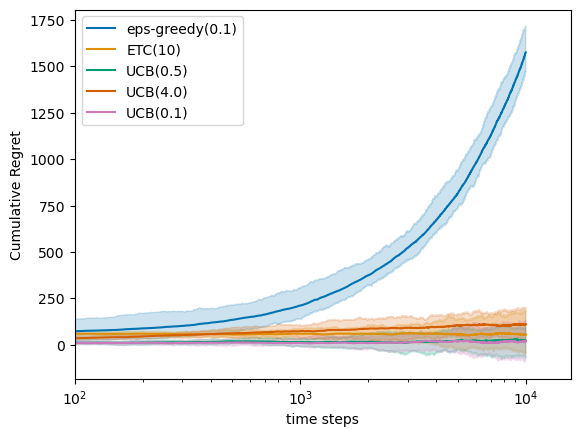

In [73]:
all_agents = experiment(small_var_GaussianBandit, [agent1, agent2, UCB_exact, badUCB, lowvarUCB], Nmc=30, T=10000)
plot_regret(all_agents, logscale=True)

In [47]:
means = np.array([0., 1., 2., 3.])
var = 0.5
gaussian_bandit = Bandit(means, model='gaussian', var=var)

eps_greedy = EpsGreedy(gaussian_bandit, epsilon=0.1)
etc_agent = ETC(gaussian_bandit, m=10)  
ucb_agent = UCB(gaussian_bandit, var=var)


all_agents = experiment(gaussian_bandit, [eps_greedy, etc_agent, ucb_agent], 
                        Nmc=50, T=10000)  

## Step 4: Optimality check

As seen in class, there is a theoretical way to check that a policy is (close to) optimal: compare its regret with the (problem-dependent) lower bound. 

In [48]:
def LB(environment, T):
    means = environment.means # the LB is NOT a policy, it is an information-theoretic quantity
    var = environment.var
    gaps = np.max(means) - means
    nonzero_gaps = gaps[gaps>0.]
    # compute the Gaussian LB:
    lb_coeff = np.sum([2*var/gap for gap in nonzero_gaps])
    return lb_coeff*np.log(np.arange(T)+1)

In [49]:
LB = LB(basicGaussianBandit, 10000)

C:\Users\mertb\AppData\Local\Temp\ipykernel_12836\3855624351.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


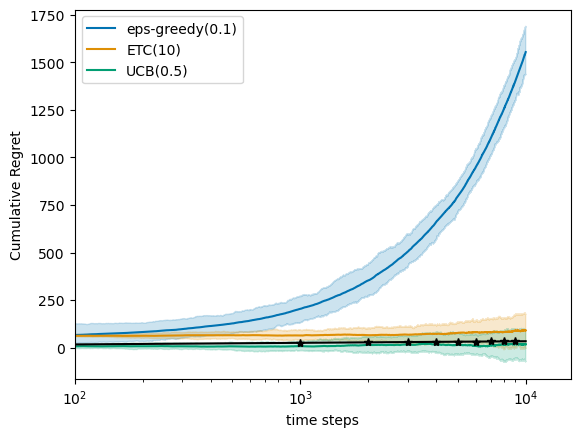

In [50]:
plot_regret(all_agents, lb=LB, logscale=True)

### Remark:
UCB does seem close to optimal... it'd be nice to see it more clearly though. Try the log-scale option of the plot function and run the experiment on a longer horizon (the lower bound is asymptotic!)